# 0.0. IMPORTS

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.1. Helper Functions

## 0.2. Load Data

In [83]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [84]:
df_raw.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


# 1.0. Descrição dos Dados

In [85]:
df1 = df_raw.copy()

In [86]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1. Dimensão dos Dados

In [87]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de linhas: 381109
Número de Colunas: 12


## 1.2. Tipo dos Dados

In [88]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Valida NA

In [89]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Análise Descritiva

In [90]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [91]:
# Tendencia central - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [92]:
df2 = df1.copy()

In [93]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [94]:
df2['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object

In [95]:
# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                   if x == '1-2 Year' else 'below_1_year' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 ) 

# 3.0. Filtragem dos Dados

In [96]:
df3 = df2.copy()

Como não tem dados visivelmente discrepantes ou com outlayers não farei filtragem neste ciclo.

# 4.0. Análise Exploratória dos Dados

In [97]:
df4 = df3.copy()

## 4.1. Análise Univariada

<AxesSubplot:xlabel='response', ylabel='age'>

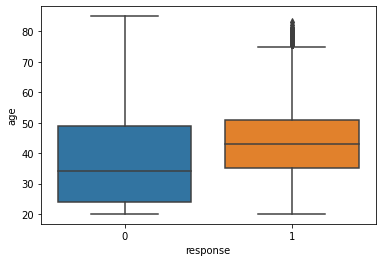

In [98]:
# 'age'
sns.boxplot( x='response', y='age', data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

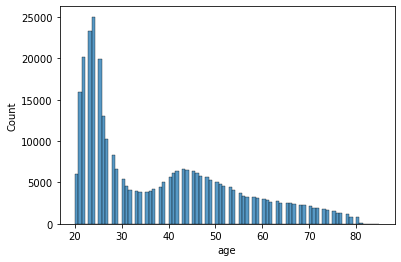

In [99]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

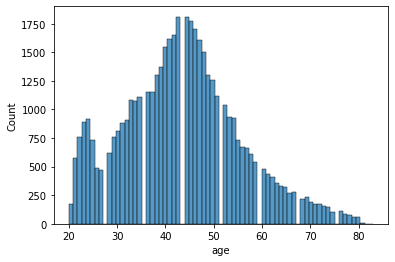

In [100]:
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux01 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

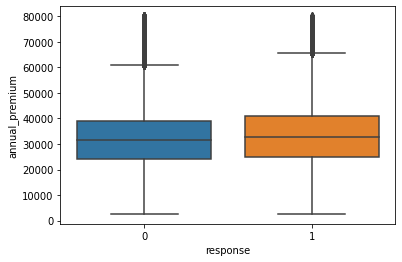

In [101]:
# 'annual_premium'
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

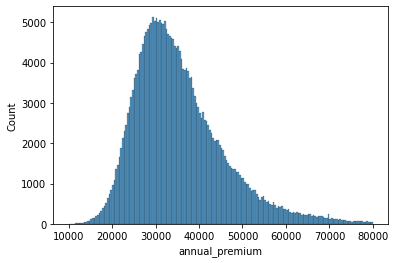

In [102]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

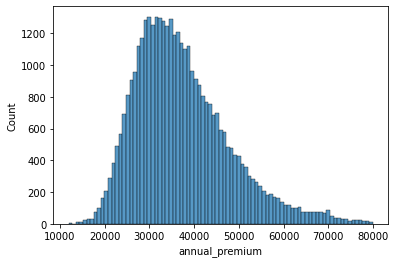

In [103]:
aux01 = aux.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux01 )

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


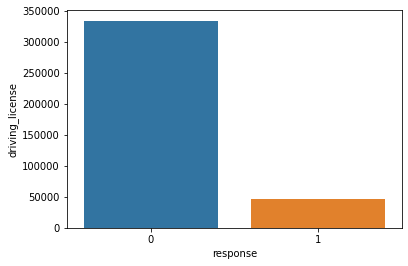

In [104]:
# 'driving_license'
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot( x='response', y='driving_license', data=aux)
aux.head()

<AxesSubplot:xlabel='region_code', ylabel='id'>

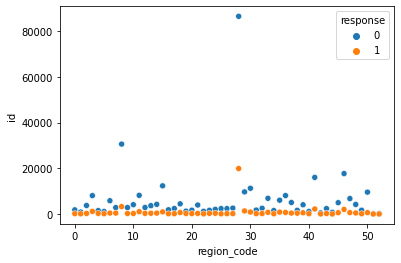

In [105]:
# 'region_code'
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
aux0
sns.scatterplot( x='region_code', y='id', hue='response', data=aux0)

In [106]:
# 'previously_insured'
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [107]:
# 'vehicle_age'
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [108]:
df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()

,response,driving_license
0,0,333628
1,1,46669


In [109]:
df4[['driving_license', 'response']].value_counts('response').reset_index()

,response,0
0,0,334399
1,1,46710


In [110]:
# 'vehicle_damage'
df4['vehicle_damage']

0         1
1         0
2         0
3         0
4         1
         ..
381104    0
381105    1
381106    0
381107    1
381108    1
Name: vehicle_damage, Length: 381109, dtype: int64

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

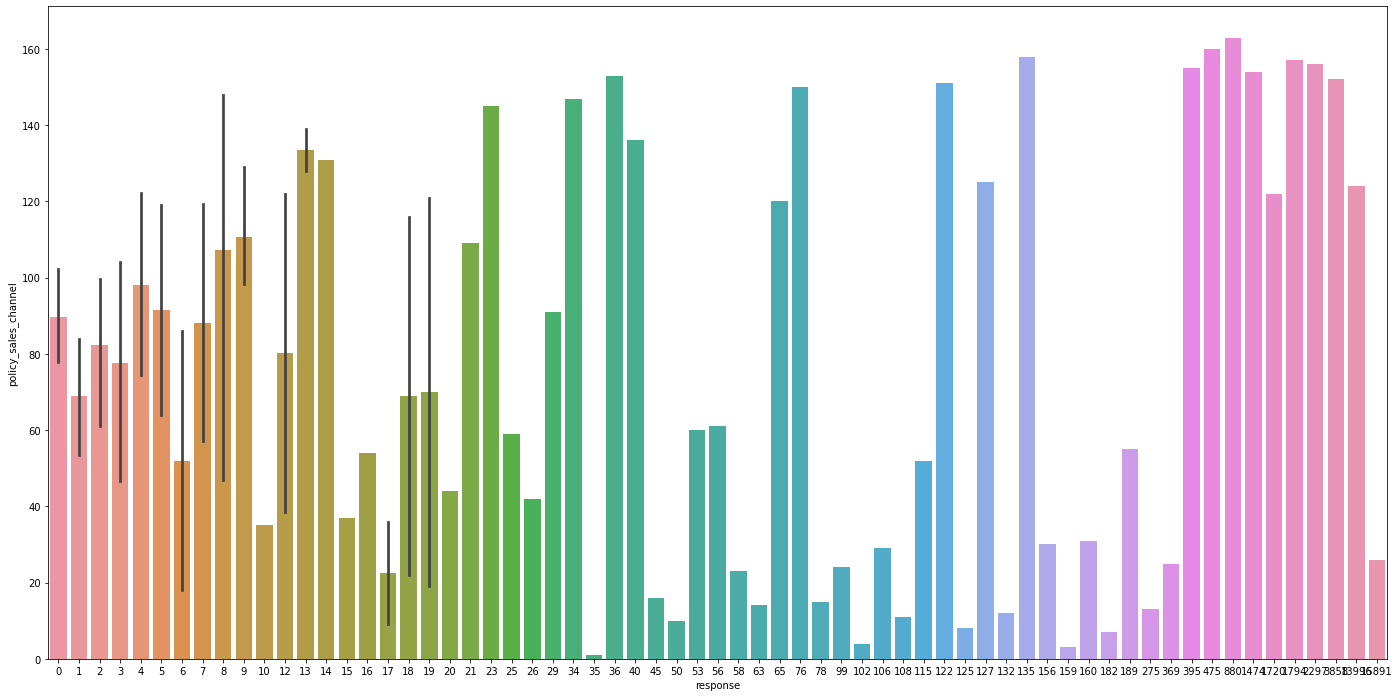

In [111]:
# 'policy_sales_channel'
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.figure( figsize=(24, 12))

sns.barplot( x='response', y='policy_sales_channel', data=aux)

<AxesSubplot:xlabel='response', ylabel='vintage'>

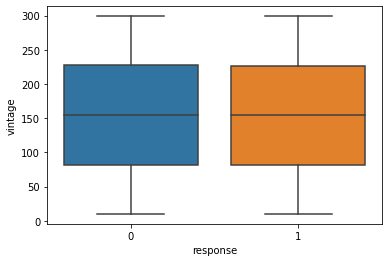

In [112]:
# 'vintage'
sns.boxplot( x='response', y='vintage', data=df4 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

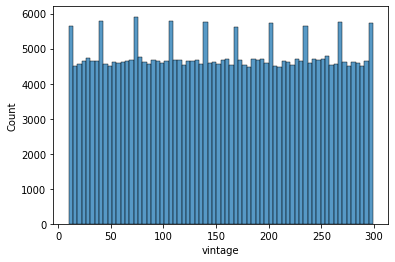

In [113]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

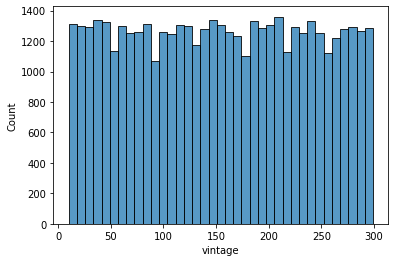

In [114]:
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux01 )

<AxesSubplot:xlabel='gender', ylabel='Count'>

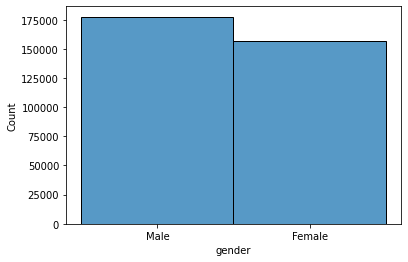

In [115]:
# gender
aux02 = df4.loc[df4['response'] == 0, 'gender']
sns.histplot( aux02 )

<AxesSubplot:xlabel='gender', ylabel='Count'>

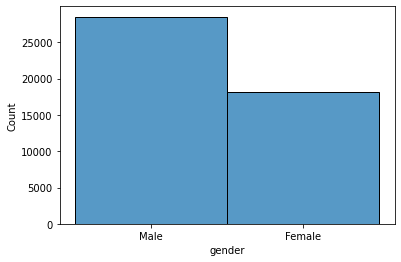

In [116]:
aux02 = df4.loc[df4['response'] == 1, 'gender']
sns.histplot( aux02 )

<AxesSubplot:xlabel='gender', ylabel='Count'>

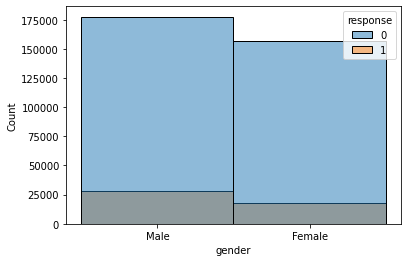

In [117]:
sns.histplot(x='gender', data=df4, hue='response' )

## 4.2. Análise Bivariada

# 5.0. Preparação dos Dados

In [118]:
x = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.2 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization 

In [119]:
ss = pp.StandardScaler()

In [120]:
# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [121]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [122]:
# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_age.fit_transform( df5[['vintage']].values )

## 5.3. Encoder

Como o processo de Encoder subjetivo é para uma maior assertividade é necessário testar as possibilidades, neste ciclo será utilizado uma forma de encoding e nos proximos podem ser testados as outras possibilidades.

**Possibilidades de encodigng** -> One Hot Encoding / Frequency Encoding / Target Encoding / Weighted Target Encoding / Order Encoding

In [123]:
# gender -> One Hot Encoding / Frequency Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code -> Target Encoding / Frequency Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age -> One Hot Encoding / Order Encoding / Frequency Encoding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - > Frequency Encoding / Target Encoding
te_policy_sales_chanel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( te_policy_sales_chanel )

## 5.4. Validation Preparation

In [124]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( te_policy_sales_chanel )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# vintage
x_validation.loc[:, 'vintage'] = mms_age.fit_transform( x_validation[['vintage']].values )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

x_validation = x_validation.fillna( 0 )

In [125]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
44974,358631,0.138365,0.107266,1,0.085290,0,1,-1.604500,0.209009,0.550173,0,1,0
187366,354411,0.138365,0.193772,1,0.187335,0,1,-1.604500,0.194675,0.179931,0,1,0
104941,75154,0.138365,0.058824,1,0.126438,1,0,-1.604500,0.353305,0.249135,1,0,0
93307,363449,0.103645,0.041522,1,0.094676,0,1,-0.100377,0.056998,0.761246,1,0,0
212375,171835,0.138365,0.131488,1,0.187335,0,1,2.009299,0.209009,0.681661,0,1,0


# 6.0. Feature Selection

## 6.1. Importância das Features

In [126]:
# Definção do modelo
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df5.drop( ['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking
                        feature  importance
0                       vintage    0.273198
0                annual_premium    0.245218
0                           age    0.166478
0                   region_code    0.104950
0                vehicle_damage    0.067279
0          policy_sales_channel    0.059429
0            previously_insured    0.056751
0      vehicle_age_below_1_year    0.013882
0  vehicle_age_between_1_2_year    0.005634
0                        gender    0.004676
0      vehicle_age_over_2_years    0.002031
0               driving_license    0.000474


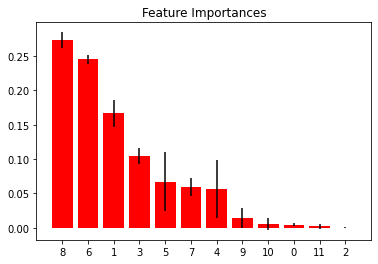

In [127]:
def Feature_ranking(forest, x_train_n, plot=True):
    importances = forest.feature_importances_
    std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
    indices = np.argsort( importances )[::-1]

    print('Feature Ranking')
    df = pd.DataFrame()
    for i, j in zip( x_train_n, forest.feature_importances_ ):
        aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
        df = pd.concat( [df, aux], axis=0)
        
    print( df.sort_values( 'importance', ascending=False))
    
    if plot:
        plt.figure()
        plt.title('Feature Importances')
        plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
        plt.xticks( range(x_train_n.shape[1]), indices )
        plt.xlim( [-1, x_train_n.shape[1]] )
        plt.show()
    
Feature_ranking(forest, x_train_n)

# 7.0. Modelagem de machine learning

In [128]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1. KNN

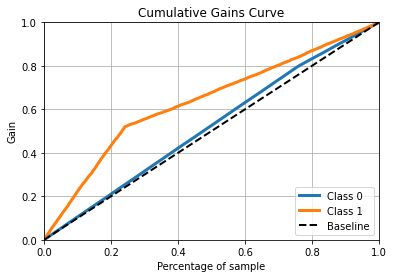

In [129]:
# Model Definition
knn_model = nh.KNeighborsClassifier( n_neighbors=2 )

# Model training
knn_model.fit( x_train, y_train )

# Model Prediction
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

## 7.2. Logistic Regression

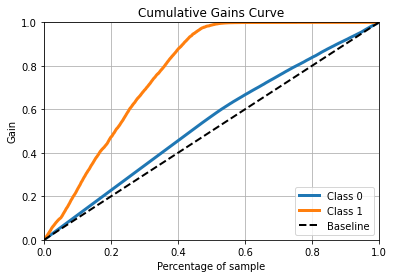

In [130]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=42 )

# Model training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## 7.3. Extra Trees

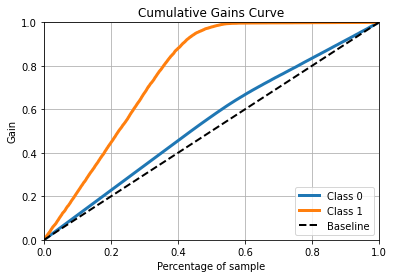

In [51]:
# Model Definition - usando -3 para deixar 2 cores livres para não travar o PC.
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-3, random_state=42 )

# Model training
et_model.fit( x_train, y_train )

# Model Prediction
yhat_et = et_model.predict_proba( x_val )

# Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

# 8.0. Performance

In [177]:
def Precision_at_k( data, k=2000, column_target='response'):

    # sort clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data[column_target].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [178]:
def Recall_at_k( data, k=2000, column_target='response'):
    
    # sort clients by propensity score
    data = data.sort_values( 'score', ascending=False )

    # Reset Index
    data = data.reset_index( drop=True )

    # Create Ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data[column_target].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

## 8.1. Performance at K - KNN

In [179]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity Score
df8['score'] = yhat_knn[:,1].tolist()

# Compute precision at K
precision_at_50 = Precision_at_k(df8, 50)
print(f'Precision at K:{precision_at_50}')
      
# Compute recall at K
recall_at_50 = Recall_at_k(df8, 50)
print(f'Recall at K:{recall_at_50}')

Precision at K:0.3137254901960784
Recall at K:0.0017050298380221654


# 9.0. Ajuste fino de hiperparâmetros

# 10.0. Converter o desempenho do modelo em valores de negócios

# 11.0. Implantar o Modelo em Produção